# Data Analytics project - prediction of electric current prices

### Libraries

In [119]:
import datetime
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import time
from typing import List

from cmdstanpy import CmdStanModel
from sklearn.metrics import mean_squared_error

### Importing data

In [120]:
df_ceny: pd.DataFrame = pd.read_csv("Prices/PL_CENY_NIEZB_RB_20190301_20190331_20200614080414.csv", sep=";", decimal=",")
df_zapotrzebowanie: pd.DataFrame = pd.read_csv("Load/PL_WYK_KSE_20190301_20190331_20190401010535.csv", encoding="cp1250", sep=";", decimal=",")
df_ceny["Data_i_Godzina"] = df_ceny["Data"].astype(str) + " - " + df_ceny["Godzina"].astype(str)
df_ceny = df_ceny[["Data", "Godzina", "Data_i_Godzina", "CRO"]]
df_zapotrzebowanie["Data_i_Godzina"] = df_zapotrzebowanie["Data"].astype(str) + " " + (df_zapotrzebowanie["Godzina"] - 1).astype(str) # Hours 1-24, changed into 0-23
df_zapotrzebowanie["Data_i_Godzina"] = df_zapotrzebowanie["Data_i_Godzina"].apply(datetime.datetime.strptime, args=("%Y-%m-%d %H",))
df_zapotrzebowanie["Dzień tygodnia"] = df_zapotrzebowanie["Data"].astype(str).apply(lambda x: pd.Timestamp(x).day_of_week)
df_list: List[pd.DataFrame] = []
df_naslonecznienie_temp: pd.DataFrame
for file in os.listdir("Weather2019"):
    df_naslonecznienie_temp = pd.read_csv(f"Weather2019/{file}", header=6, skipfooter=11, engine="python")
    df_naslonecznienie_temp = df_naslonecznienie_temp.loc[:, ["time", "G(i)", "T2m", "WS10m"]]
    # df_naslonecznienie_temp = df_naslonecznienie_temp.loc[:, ["time", "Gb(i)", "Gd(i)", "Gr(i)", "T2m", "WS10m"]]
    # df_naslonecznienie_temp["G(i)"] = df_naslonecznienie_temp[["Gb(i)", "Gd(i)", "Gr(i)"]].sum(axis=1)
    df_naslonecznienie_temp["time"] = df_naslonecznienie_temp["time"].apply(str.__getitem__, args=(slice(None, -2, None),))
    df_naslonecznienie_temp["time"] = df_naslonecznienie_temp["time"].apply(datetime.datetime.strptime, args=("%Y%m%d:%H",))
    df_list.append(df_naslonecznienie_temp)
df_naslonecznienie: pd.DataFrame = pd.concat(df_list)
df_naslonecznienie = df_naslonecznienie.groupby("time").mean().reset_index()
# df_naslonecznienie["time"] -= datetime.timedelta(minutes=10)
df_naslonecznienie_marzec = df_naslonecznienie.loc[
    df_naslonecznienie["time"].between(datetime.datetime(2019, 3, 1), datetime.datetime(2019, 4, 1), inclusive="left")
    ]
df_naslonecznienie_marzec.reset_index(inplace=True)


## Load - prior

### Regression - finding coefficients for 5th degree polynomial regression

(96, 2)


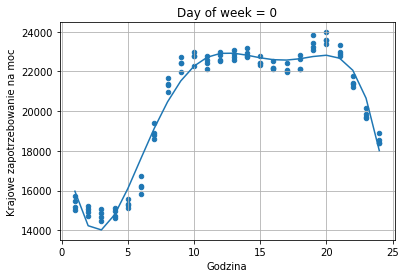

[-9.51772728e-02  6.17008966e+00 -1.46568872e+02  1.49657440e+03
 -5.29053654e+03  1.99003960e+04]
(96, 2)


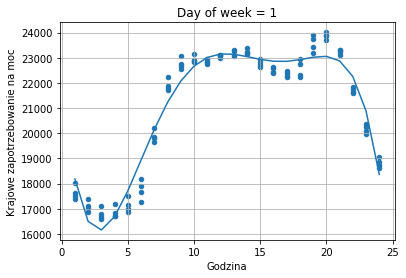

[-8.43528518e-02  5.43505860e+00 -1.28634403e+02  1.31740955e+03
 -4.81565452e+03  2.18021898e+04]
(96, 2)


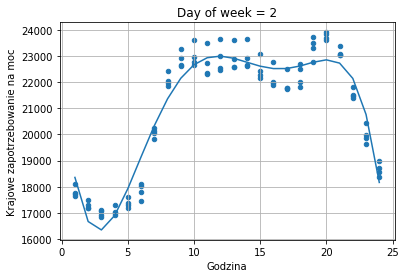

[-8.90020366e-02  5.69693666e+00 -1.33430694e+02  1.34777213e+03
 -4.87652548e+03  2.20120193e+04]
(96, 2)


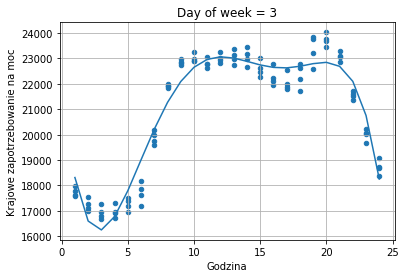

[-8.59978858e-02  5.53947530e+00 -1.30857786e+02  1.33570196e+03
 -4.88398998e+03  2.19871565e+04]
(120, 2)


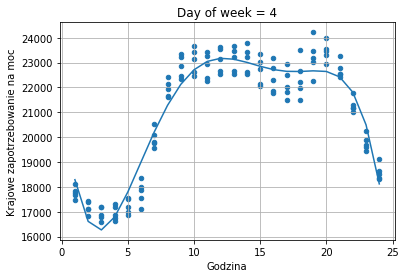

[-8.13782964e-02  5.28236019e+00 -1.25976021e+02  1.29779692e+03
 -4.76551107e+03  2.18751417e+04]
(120, 2)


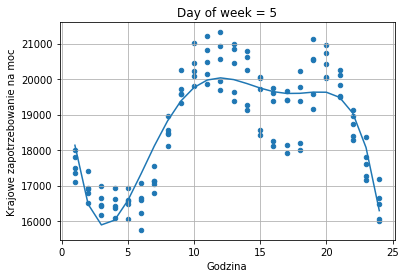

[-6.23679857e-02  4.06695537e+00 -9.78700150e+01  1.03192035e+03
 -4.13219885e+03  2.13306456e+04]
(119, 2)


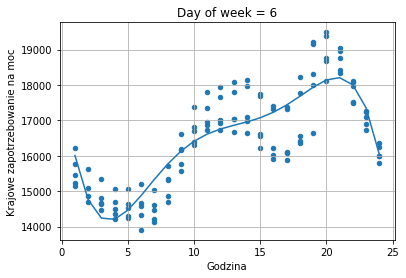

[-4.32771266e-02  2.74558358e+00 -6.47038340e+01  6.86344870e+02
 -2.89251536e+03  1.82766899e+04]


In [121]:
coeffs: List[np.ndarray] = []
for day in range(7):
    data = df_zapotrzebowanie[["Godzina", "Krajowe zapotrzebowanie na moc"]].loc[df_zapotrzebowanie["Dzień tygodnia"] == day]
    print(data.shape)
    x = data["Godzina"]
    data.plot(x="Godzina", y="Krajowe zapotrzebowanie na moc", kind="scatter", grid=True)
    plt.title(f"Day of week = {day}")
    coef = np.polyfit(x, data["Krajowe zapotrzebowanie na moc"], 5)  # Degree
    p = np.poly1d(coef)
    x = np.sort(x.drop_duplicates().to_numpy())
    plt.plot(x, p(x))
    plt.show()
    print(coef)
    coeffs.append(coef)

### First prior - normal distribution

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing


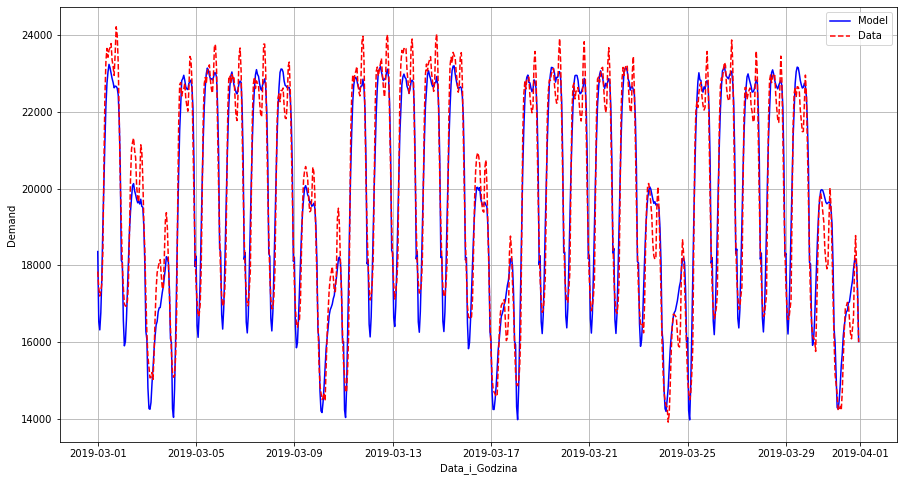

RMSE = 651.6804648760607


In [122]:
model_ppc=CmdStanModel(stan_file='model1.stan')
ppc = model_ppc.sample(show_progress=False, data=dict(
    N=len(df_zapotrzebowanie), day_of_week=df_zapotrzebowanie["Dzień tygodnia"].values, hour=df_zapotrzebowanie["Godzina"].values, 
    coeffs=coeffs
    ))
df_ppc = ppc.draws_pd()
df_ppc_mean = df_ppc.mean()[[f"demand[{i}]" for i in range(1, len(df_zapotrzebowanie) + 1)]]
plt.figure(figsize=(15, 8))
plt.plot(df_zapotrzebowanie["Data_i_Godzina"], df_ppc_mean, "b-",
         df_zapotrzebowanie["Data_i_Godzina"], df_zapotrzebowanie["Krajowe zapotrzebowanie na moc"], "r--")
plt.xlabel("Data_i_Godzina")
plt.ylabel("Demand")
plt.legend(["Model", "Data"])
plt.grid(True)
plt.show()
print(f'RMSE = {mean_squared_error(df_zapotrzebowanie["Krajowe zapotrzebowanie na moc"].values, df_ppc_mean.values, squared=False)}')

### Second prior - T-Student distribution

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing


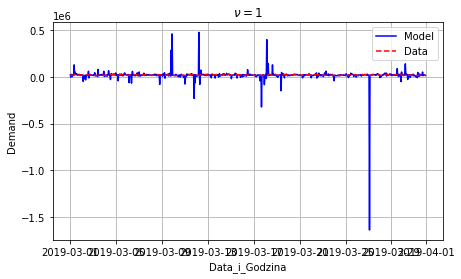

RMSE = 71360.3162511049


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing


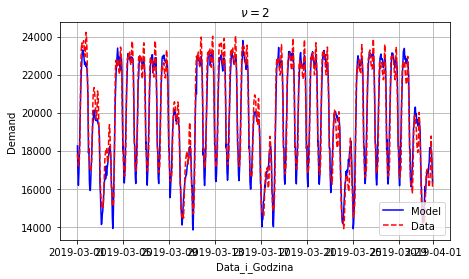

RMSE = 674.4252992905041


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing


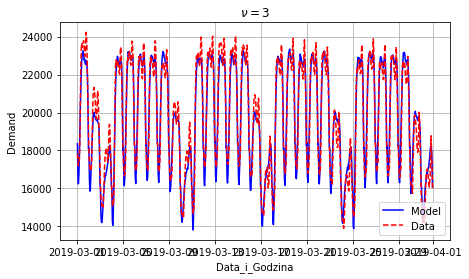

RMSE = 655.7082086262192


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing


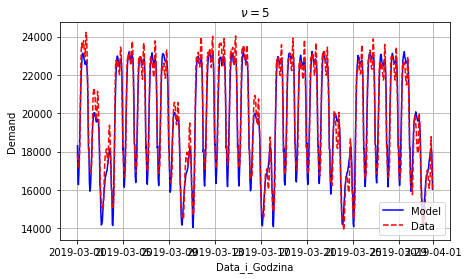

RMSE = 654.5486137133095


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing


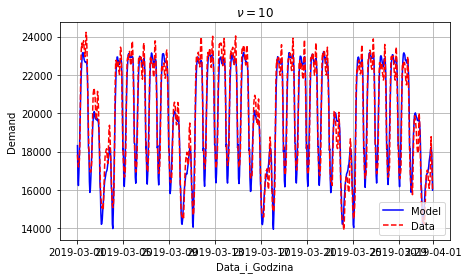

RMSE = 656.4703420025104


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing


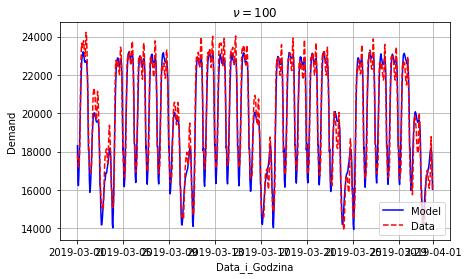

RMSE = 653.3475506193761


In [123]:
model_ppc2=CmdStanModel(stan_file='model2.stan')
for nu in [1, 2, 3, 5, 10, 100]:
    ppc2 = model_ppc2.sample(show_progress=False, data=dict(
        N=len(df_zapotrzebowanie), day_of_week=df_zapotrzebowanie["Dzień tygodnia"].values, hour=df_zapotrzebowanie["Godzina"].values, nu=nu, 
        coeffs=coeffs
        ))
    df_ppc2 = ppc2.draws_pd()
    df_ppc_mean2 = df_ppc2.mean()[[f"demand[{i}]" for i in range(1, len(df_zapotrzebowanie) + 1)]]
    plt.figure(figsize=(7, 4))
    plt.plot(df_zapotrzebowanie["Data_i_Godzina"], df_ppc_mean2, "b-",
            df_zapotrzebowanie["Data_i_Godzina"], df_zapotrzebowanie["Krajowe zapotrzebowanie na moc"], "r--")
    plt.xlabel("Data_i_Godzina")
    plt.ylabel("Demand")
    plt.grid(True)
    plt.legend(["Model", "Data"])
    plt.title(r"$\nu = $" + str(nu))
    plt.show()
    print(f'RMSE = {mean_squared_error(df_zapotrzebowanie["Krajowe zapotrzebowanie na moc"].values, df_ppc_mean2.values, squared=False)}')
    time.sleep(1)

Through experiments, it was determined that the best results (smallest value of RMSE) are achieved with nu = 5.

### Temperature's influence on the load

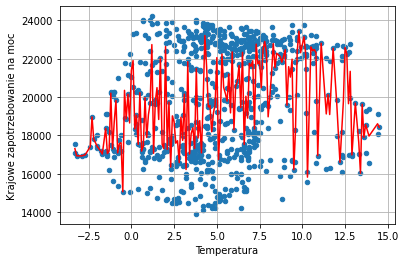

In [124]:
data = df_zapotrzebowanie[["Data_i_Godzina", "Godzina", "Krajowe zapotrzebowanie na moc"]]
# data = data[data["Godzina"].between(11, 21)]
data.insert(len(data.columns), "Temperatura", [
    round(df_naslonecznienie_marzec.loc[df_naslonecznienie_marzec["time"] == data.iloc[i]["Data_i_Godzina"]]["T2m"].values[0], 1) for i in range(len(data))
    ])
data.plot(x="Temperatura", y="Krajowe zapotrzebowanie na moc", kind="scatter", grid=True)
plt.plot(sorted(data["Temperatura"].unique()), data.groupby(["Temperatura"], sort=True).median()["Krajowe zapotrzebowanie na moc"], "r-")
plt.show()

## Generation - prior

### Determining relation with wind speed and irradiance

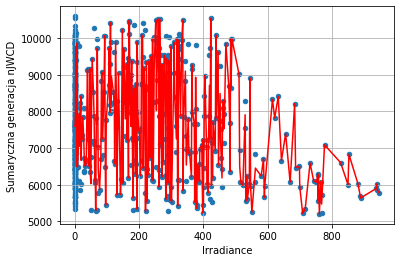

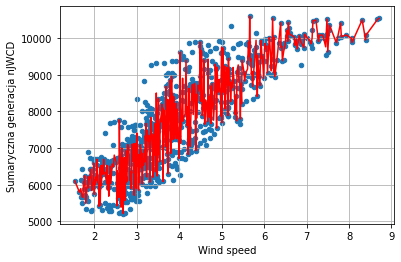

In [125]:
data = df_zapotrzebowanie[["Data_i_Godzina", "Sumaryczna generacja nJWCD"]]
data.insert(len(data.columns), "Irradiance", [
    round(df_naslonecznienie_marzec.loc[df_naslonecznienie_marzec["time"] == data.iloc[i]["Data_i_Godzina"]]["G(i)"].values[0], 0) for i in range(len(data))
    ])
data.insert(len(data.columns), "Wind speed", [
    round(df_naslonecznienie_marzec.loc[df_naslonecznienie_marzec["time"] == data.iloc[i]["Data_i_Godzina"]]["WS10m"].values[0], 2) for i in range(len(data))
    ])
data.plot(x="Irradiance", y="Sumaryczna generacja nJWCD", kind="scatter", grid=True)
plt.plot(sorted(data["Irradiance"].unique()), data.groupby(["Irradiance"], sort=True).median()["Sumaryczna generacja nJWCD"], "r-")
plt.show()
data.plot(x="Wind speed", y="Sumaryczna generacja nJWCD", kind="scatter", grid=True)
plt.plot(sorted(data["Wind speed"].unique()), data.groupby(["Wind speed"], sort=True).median()["Sumaryczna generacja nJWCD"], "r-")
plt.show()

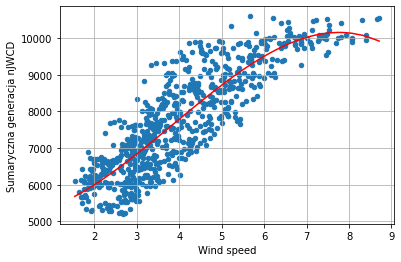

[ -20.98813787  242.92662548   23.92892529 5148.76715643]


In [126]:
x = data["Wind speed"]
data.plot(x="Wind speed", y="Sumaryczna generacja nJWCD", kind="scatter", grid=True)
coef = np.polyfit(x, data["Sumaryczna generacja nJWCD"], 3)  # Degree
p = np.poly1d(coef)
x = np.sort(x.drop_duplicates().to_numpy())
plt.plot(x, p(x), "r-")
plt.show()
print(coef)

### First prior - normal distribution

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing


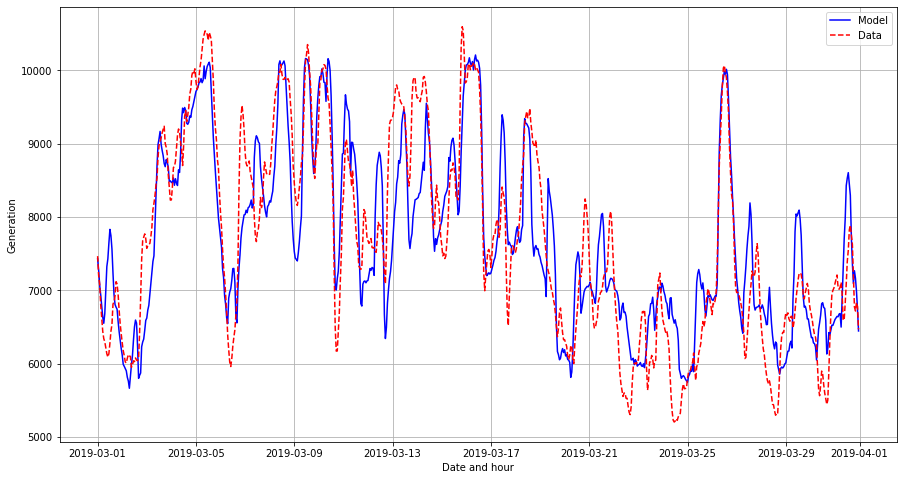

RMSE = 688.0390288573949


In [127]:
model_ppc3=CmdStanModel(stan_file='model3.stan')
ppc3 = model_ppc3.sample(show_progress=False, data=dict(
    N=len(data), wind_speed=data["Wind speed"].values, coeffs=coef
    ))
df_ppc3 = ppc3.draws_pd()
df_ppc_mean3 = df_ppc3.mean()[[f"generation[{i}]" for i in range(1, len(data) + 1)]]
plt.figure(figsize=(15, 8))
plt.plot(data["Data_i_Godzina"], df_ppc_mean3, "b-",
         data["Data_i_Godzina"], data["Sumaryczna generacja nJWCD"], "r--")
plt.xlabel("Date and hour")
plt.ylabel("Generation")
plt.legend(["Model", "Data"])
plt.grid(True)
plt.show()
print(f'RMSE = {mean_squared_error(data["Sumaryczna generacja nJWCD"].values, df_ppc_mean3.values, squared=False)}')

### Second prior - T-Student distribution

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing


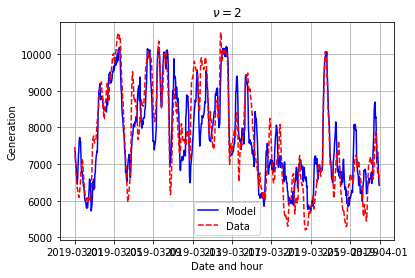

RMSE = 689.1067941862575


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing


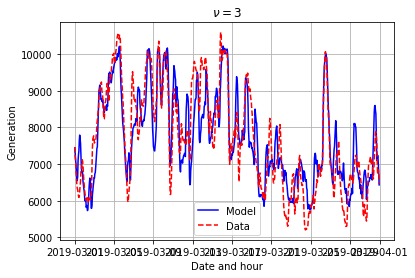

RMSE = 689.1078520837889


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing


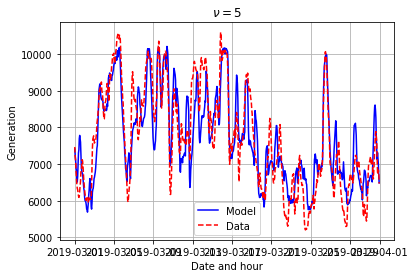

RMSE = 684.9106884326762


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing


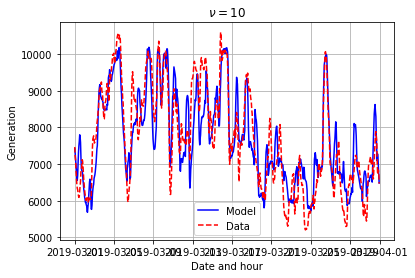

RMSE = 686.8146509271712


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing


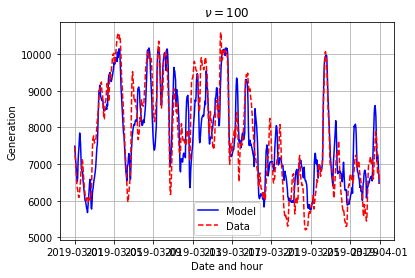

RMSE = 686.224672142191


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing


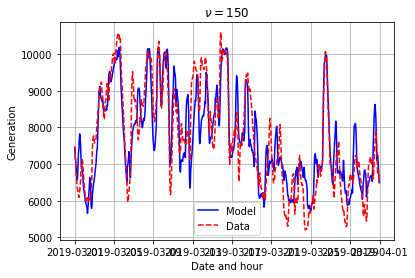

RMSE = 686.0993756211557


In [129]:
model_ppc4=CmdStanModel(stan_file='model4.stan')
for nu in [2, 3, 5, 10, 100, 150]:
    ppc4 = model_ppc4.sample(show_progress=False, data=dict(
        N=len(data), wind_speed=data["Wind speed"].values, coeffs=coef, nu=nu
        ))
    df_ppc4 = ppc4.draws_pd()
    df_ppc_mean4 = df_ppc4.mean()[[f"generation[{i}]" for i in range(1, len(data) + 1)]]
    plt.plot(data["Data_i_Godzina"], df_ppc_mean4, "b-",
            data["Data_i_Godzina"], data["Sumaryczna generacja nJWCD"], "r--")
    plt.xlabel("Date and hour")
    plt.ylabel("Generation")
    plt.grid(True)
    plt.legend(["Model", "Data"])
    plt.title(r"$\nu = $" + str(nu))
    plt.show()
    print(f'RMSE = {mean_squared_error(data["Sumaryczna generacja nJWCD"].values, df_ppc_mean4.values, squared=False)}')
    time.sleep(1)

Again, the best amount of degrees of freedom is 5.